In [1]:
import numpy as np
import healpy as hp
import h5py
import matplotlib.pyplot as plt

# Unpack maps: combined LVK O1-O2-O3 results

data from https://arxiv.org/pdf/2211.10010.pdf

In [2]:
!ls -ltr

total 939792
-rw-r--r--  1 pai  staff        158 26 Aug  2021 README_GWB.txt
-rw-r--r--  1 pai  staff       2080 26 Aug  2021 estimator.py
drwxr-xr-x  7 pai  staff        224 26 Aug  2021 galaxies
drwxr-xr-x  5 pai  staff        160 26 Aug  2021 GWB
-rw-r--r--  1 pai  staff    9451520  5 Jun 19:39 O3_HLV_combined_20-1726Hz.hdf5
-rw-r--r--  1 pai  staff  151046144  5 Jun 20:32 O1-O3_nside16_alpha0_combined_20-1726Hz.hdf5
-rw-r--r--  1 pai  staff  151046144  5 Jun 20:33 O1-O3_nside16_alpha23_combined_20-1726Hz.hdf5
-rw-r--r--  1 pai  staff  151046144  5 Jun 20:35 O1-O3_nside16_alpha3_combined_20-1726Hz.hdf5
-rw-r--r--  1 pai  staff     668768  5 Jun 22:11 unpack_maps.ipynb


### read in dirt map and Fisher matrix

include tricky factors that have to do with data handling...

In [3]:
WIN_FACTOR = 0.514285060338
BIAS = 1.05555555556

# reference frequency considered when analysing data
fref = 25 #Hz

and these are cosmo constants

In [4]:
H0 = 67.4 / 3.09e19
omega_const = 2 * np.pi**2 * fref**3 / 3 / H0**2 #converts strain power to Omega

note the $\alpha$ I'm reading in below; you can also use the other files but this is the $\alpha$ assuming binary inspirals

In [5]:
file = h5py.File('O1-O3_nside16_alpha23_combined_20-1726Hz.hdf5', 'r')
npix = len(file['dirty_map'][()])
dirty_map = 2 * file['dirty_map'][()].real / WIN_FACTOR * BIAS * 4 * np.pi**2
fisher_matrix = 2 * file['fisher'][()].real / WIN_FACTOR * BIAS * (4 * np.pi**2)**2

### visualize dirty map and clean map

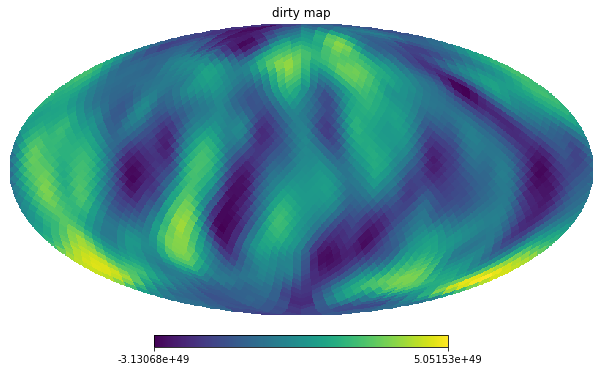

In [6]:
hp.mollview(dirty_map, rot=(180,0,0), title='dirty map')

calculate inverse fisher matrix - this will look very different depending on the conditioning cutoff.

In [7]:
fisher_inv = np.linalg.pinv(fisher_matrix, rcond=3.e-6)

In [8]:
clean_map = fisher_inv @ dirty_map 

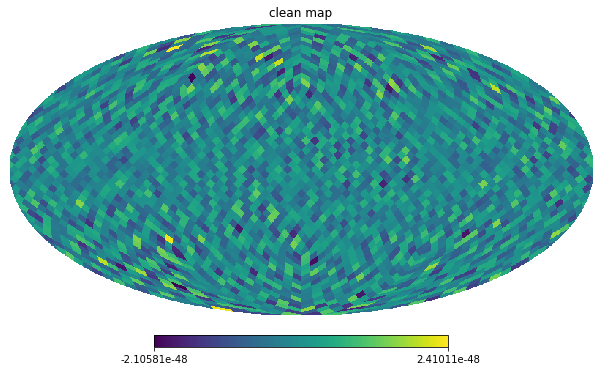

In [9]:
hp.mollview(clean_map, rot=(180,0,0), title='clean map')

the units of this map are strain power. This is a map of the GW strain power at reference frequency 25Hz assuming a spectral index of $\alpha=2/3$

to see this in $\Omega_{\rm GW}$ units, simply

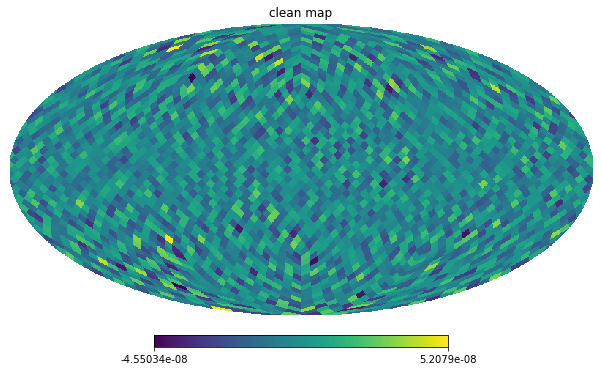

In [10]:
hp.mollview(clean_map*omega_const, rot=(180,0,0), title='clean map')

note the fluctuations: it's all just noise.

In [11]:
noise_map = np.diag(fisher_inv) ** 0.5

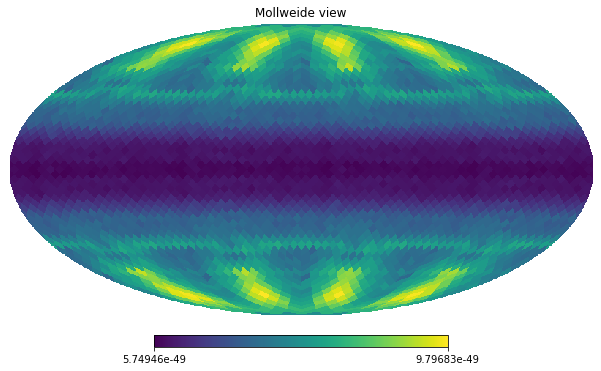

In [12]:
hp.mollview(noise_map)

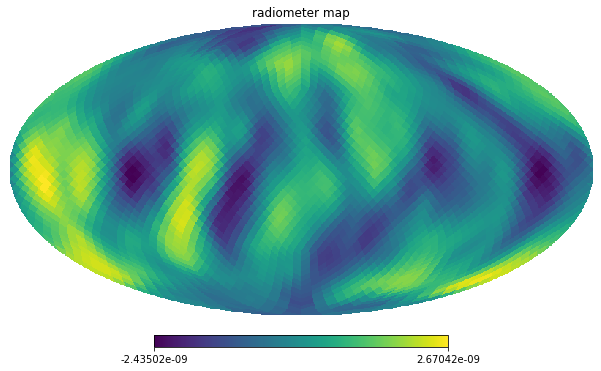

In [13]:
hp.mollview(dirty_map/np.diag(fisher_matrix) * omega_const, rot=(180,0,0), title='radiometer map')

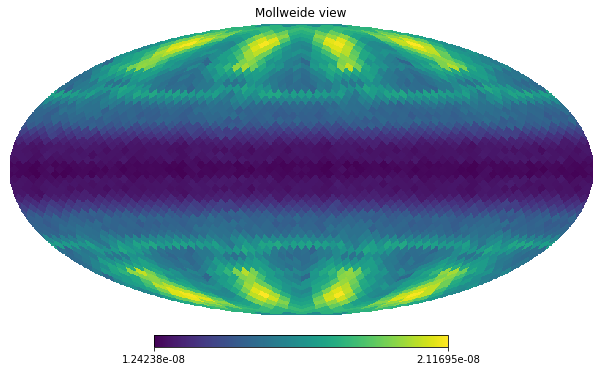

In [14]:
hp.mollview(noise_map*omega_const)

just for comparison, let's look at the radiometer map. see how pattern matches https://journals.aps.org/prd/pdf/10.1103/PhysRevD.104.022005 fig. 2, although that's an upper-limits radiometer map. 

### Calculate $C_\ell$s

LIGO results for $C_\ell$s are in ~ 1/steradian**2, so we convert to this in this script.

In [15]:
def unpack_alm(alm):
    #lmaxA = np.sqrt(len(A)) - 1
    lmax = np.int((np.sqrt(1 + 8 * len(alm)) - 3) / 2)
    lm_dim = lmax * (lmax + 2) + 1

    out = np.zeros(lm_dim, dtype=np.complex)

    for l in range(0, lmax + 1):
        idx_l = l * (l + 1)
        for m in range(0, l + 1):
            msign = (-1) ** m
            idx = hp.Alm.getidx(lmax, l, m)
            if m == 0:
                out[idx_l] = alm[idx]
            else:
                out[idx_l + m] = alm[idx]
                out[idx_l - m] = msign * np.conj(alm[idx])
    return out

def pack_alm(alm):
    lmax = np.int(np.sqrt(len(alm)) - 1)
    lm_dim = (lmax + 1) * (lmax + 2) // 2
    out = np.zeros(lm_dim, dtype=np.complex)
    for idx in range(lm_dim):
        l, m = hp.Alm.getlm(lmax, idx)
        idx_lm = l * (l + 1) + m
        out[idx] = alm[idx_lm]
    return out

def calc_Cl(fisher, clean_map, lmax=16):
    '''
    Compute the 95% upper limits on Cl's
    '''
    npix = len(clean_map)
    len_alm = hp.Alm.getsize(lmax)

    dirty_map_cond = fisher @ clean_map
    dmap_cond_lm = np.conj(hp.map2alm(dirty_map_cond, lmax=lmax, pol=False))

    lm_dim = lmax * (lmax + 2) + 1
    rlm_dim = (lmax + 1) * (lmax + 2) // 2

    fisher_copy = np.copy(fisher)
    cplm = np.zeros((rlm_dim, npix), dtype=np.complex)
    for p in range(npix):
        cplm[:, p] = np.conj(hp.map2alm(fisher_copy[p, :], lmax=lmax, pol=False))

    clmlm = np.zeros((lm_dim, lm_dim), dtype=np.complex)
    for l in range(0, lmax + 1):
        idxl = l * (l + 1)
        for m in range(0, l + 1):
            idx_lmp = idxl + m
            idx_lmm = idxl - m
            msign = (-1) ** m
            idx = hp.Alm.getidx(lmax, l, m)
            ralm = hp.map2alm(np.real(cplm[idx, :]), lmax=lmax)
            ialm = 1j * hp.map2alm(np.imag(cplm[idx, :]), lmax=lmax)

            if m == 0:
                for lp in range(0, lmax + 1):
                    idx_lp = lp * (lp + 1)
                    for mp in range(0, lp + 1):
                        mpsign = (-1) ** mp
                        jdx = hp.Alm.getidx(lmax, lp, mp)
                        clmlm[idx_lmp, idx_lp + mp] = ralm[jdx] + ialm[jdx]
                        if mp > 0: clmlm[idx_lmm, idx_lp - mp] = mpsign * np.conj(clmlm[idx_lmp, idx_lp + mp])
            else:
                for lp in range(0, lmax + 1):
                    idx_lp = lp * (lp + 1)
                    for mp in range(0, lp + 1):
                        mpsign = (-1) ** mp
                        jdx = hp.Alm.getidx(lmax, lp, mp)
                        clmlm[idx_lmp, idx_lp + mp] = ralm[jdx] + ialm[jdx]
                        clmlm[idx_lmm, idx_lp + mp] = msign * (ralm[jdx] - ialm[jdx])
                        if mp > 0:
                            clmlm[idx_lmm, idx_lp - mp] = msign * mpsign * np.conj(clmlm[idx_lmp, idx_lp + mp])
                            clmlm[idx_lmp, idx_lp - mp] = mpsign / msign * np.conj(clmlm[idx_lmm, idx_lp + mp])

    clmlm = np.asmatrix(clmlm)

    ninv = np.linalg.inv(clmlm)
    dmap_cond_lm_full = unpack_alm(dmap_cond_lm)
    alm = (ninv @ dmap_cond_lm_full) / len(dirty_map_cond)

    alm_new = pack_alm(np.array(alm)[0])
    clm_new = pack_alm(np.sqrt(np.real(np.diag(ninv)))) / len(dirty_map_cond)

    nl = hp.alm2cl(clm_new)
    cl = hp.alm2cl(alm_new) - nl

    ell = np.arange(len(cl))
    sig_cl = np.sqrt(2 / (2 * ell + 1)) * nl
    upp_lim_cl = []
    for i in range(len(cl)):
        val = (cl[i] + 1.96 * sig_cl[i]) * (npix / 4 / np.pi)**2 # 4pi/npix : area of a pixel in steradians.
        if val > 0:
            upp_lim_cl.append(val)
        else:
            #for negative Cl, assume it's == 0...
            upp_lim_cl.append(1.96 * sig_cl[i] * (npix / 4 / np.pi)**2)
    upp_lim_cl = np.array(upp_lim_cl)
    #upp_lim_Dell = upp_lim_cl * ell * (ell + 1) / (2 * np.pi)
    upp_lim_Dell = upp_lim_cl * (2 * ell + 1) / (4 * np.pi) # ref suggestion
    norm_term = (8 * np.pi / 5) ** 2 # normalisation: due to unnormalised overlap reduction function
    return upp_lim_cl * omega_const**2 * norm_term, upp_lim_Dell * omega_const**2 * norm_term

In [16]:
cl_23, dell_23 = calc_Cl(fisher_matrix, clean_map)

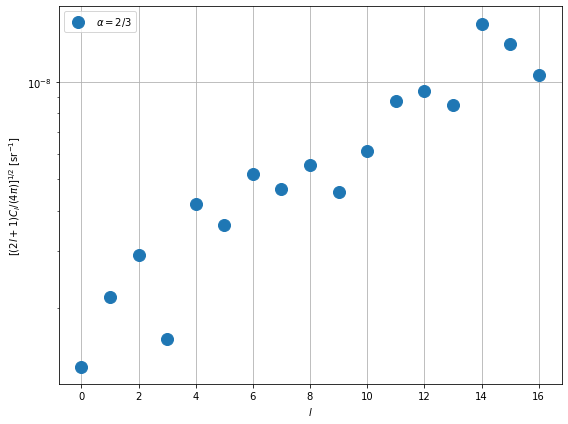

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(cl_23), 'o', ms=12, label=r'$\alpha=2/3$')
plt.yscale('log')
plt.grid()
plt.xlabel('$l$')
plt.ylabel('$[(2l+1)C_l/(4\pi)]^{1/2}$ [sr$^{-1}$]')
plt.legend()
plt.tight_layout()

(can be directly compared with fig. 4 in  https://journals.aps.org/prd/pdf/10.1103/PhysRevD.104.022005, at low $\ell$)

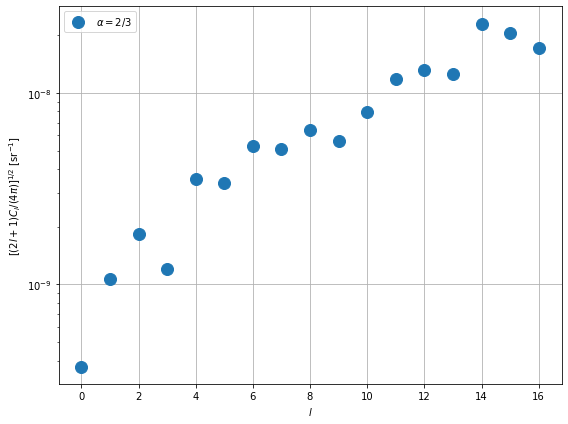

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(dell_23), 'o', ms=12, label=r'$\alpha=2/3$')
plt.yscale('log')
plt.grid()
plt.xlabel('$l$')
plt.ylabel('$[(2l+1)C_l/(4\pi)]^{1/2}$ [sr$^{-1}$]')
plt.legend()
plt.tight_layout()